# a.i. Depression Classification

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Cleaning

In [2]:
#Function to clean the data
def data_cleaning(file_path):
    df = pd.read_csv(file_path, index_col=0)
    df.dropna(inplace=True)

    return df

In [3]:
train_file = "/content/sample_data/final_training_data.csv"
test_file = "/content/sample_data/final_testing_data.csv"

# train_file = "../Datasets/ADS/final_training_data.csv"
# test_file = "../Datasets/ADS/final_testing_data.csv"

#After data exploring we found that one of the data sample's turn was all NA. So we removed it
train_data_source = data_cleaning(train_file)
test_data = data_cleaning(test_file)

# Training

In [4]:
from sklearn.model_selection import train_test_split

#Select the features and target variables from the train set
X_tr = train_data_source.drop(['Depression', 'Gender', 'participant_id'], axis=1)
y_tr = train_data_source['Depression']
feature_names = X_tr.columns
gender = train_data_source['Gender']

#Normalize the data using standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)

#Split the data into training and validation set
X_train, X_val, y_train, y_val, genders_train, genders_val = train_test_split(X_tr_scaled, y_tr, gender, test_size=0.2, random_state=42)

In [6]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape, genders_train.shape)

(10900, 88) (2725, 88) (10900,) (2725,) (10900,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [None, 20, 40],  # Maximum number of levels in tree
    'min_samples_split': [5, 10]  # Minimum number of samples required to split a node
}

#Initialize the classifier
rf = RandomForestClassifier(random_state=42)

#Setup the grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

#Fit grid_search to the data
grid_search.fit(X_train, y_train)


#Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

#Best model from grid search
best_rf = grid_search.best_estimator_

#Predict on the validation set
y_pred = best_rf.predict(X_val)

#Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
Validation Accuracy: 0.8469724770642202


In [7]:
rf_best = RandomForestClassifier(max_depth=None, max_features= 'sqrt', min_samples_split= 5,
                                    n_estimators=300, random_state=42)
rf_best.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=300, random_state=42)

# Performing predictions on the test data

In [8]:
#Function to aggregate turn-based decisions at the participant level
def aggregate_decisions(decisions):
    return int(decisions.mean() >= 0.5)

In [9]:
#Select the features and target variables from the test set
X_test = test_data.drop(['Depression', 'Gender', 'participant_id'], axis=1)
y_test = test_data['Depression']

#Normalize the test data using the scaler fitted on the training data
X_test = scaler.transform(X_test)

#Make predictions on the test set
y_pred_test = rf_best.predict(X_test)

In [10]:
'''
Aggregrate predictions on a participant level
'''
#Get the participant IDs and genders for the test set
participant_ids_test = test_data['participant_id']
genders_test = test_data['Gender']

#Aggregate the predictions at the participant level
def aggregate_predictions(y_pred_test):
  participant_preds_test = {} #Have turns predictions for each participant
  for participant_id, pred in zip(participant_ids_test, y_pred_test):
      if participant_id not in participant_preds_test:
          participant_preds_test[participant_id] = []
      participant_preds_test[participant_id].append(pred)

  participant_final_preds_test = {} #Store aggregrated results
  for participant_id, preds in participant_preds_test.items():
      participant_final_preds_test[participant_id] = aggregate_decisions(pd.Series(preds))
  return participant_final_preds_test

In [11]:
#Evaluate the predictions against the true labels
participant_final_preds_test = aggregate_predictions(y_pred_test)
y_true_test = y_test.groupby(participant_ids_test).mean().round().astype(int)
y_pred_final_test = pd.Series(participant_final_preds_test)

In [12]:
#Calculate accuracy and balanced accuracy
accuracy_test = accuracy_score(y_true_test, y_pred_final_test)
balanced_accuracy_test = balanced_accuracy_score(y_true_test, y_pred_final_test)

#Calculate equality of opportunity (EO) for the test set
def calculate_tpr(y_true_test, y_pred_final_test):
  genders_test_aggregated = genders_test.groupby(participant_ids_test).first()
  male_mask_test = (genders_test_aggregated == 1)
  female_mask_test = (genders_test_aggregated == 0)

  tpr_male_test = accuracy_score(y_true_test[male_mask_test], y_pred_final_test[male_mask_test])
  tpr_female_test = accuracy_score(y_true_test[female_mask_test], y_pred_final_test[female_mask_test])

  return [male_mask_test, female_mask_test, tpr_male_test, tpr_female_test]

mask_and_tpr = calculate_tpr(y_true_test, y_pred_final_test)
male_mask_test, female_mask_test, tpr_male_test, tpr_female_test = mask_and_tpr[0], mask_and_tpr[1], mask_and_tpr[2], mask_and_tpr[3]
eo_test = 1 - abs(tpr_male_test - tpr_female_test)

In [13]:
#Print the evaluation metrics for the test set
print("Test Accuracy:", accuracy_test)
print("Test Balanced Accuracy:", round(balanced_accuracy_test,3))
print("Test Equality of Opportunity (EO):", round(eo_test,3))

#Print the evaluation metrics for male and female participants separately
print("Male Accuracy:", round(tpr_male_test,3))
print("Female Accuracy:", round(tpr_female_test,3))
print("Male Balanced Accuracy:", round(balanced_accuracy_score(y_true_test[male_mask_test], y_pred_final_test[male_mask_test]),3))
print("Female Balanced Accuracy:", balanced_accuracy_score(y_true_test[female_mask_test], y_pred_final_test[female_mask_test]))

Test Accuracy: 0.65
Test Balanced Accuracy: 0.464
Test Equality of Opportunity (EO): 0.542
Male Accuracy: 0.833
Female Accuracy: 0.375
Male Balanced Accuracy: 0.455
Female Balanced Accuracy: 0.5


**b. Feature Selection**

In [14]:
#Feature selection using mutual information

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix

info = mutual_info_classif(X_train, y_train)
features_ranked = feature_names[np.argsort(-info)]

In [15]:
selected_features = features_ranked[:20]
print(selected_features)

Index(['loudness_sma3_pctlrange0-2', 'equivalentSoundLevel_dBp',
       'loudness_sma3_percentile80.0', 'loudness_sma3_amean',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'spectralFluxV_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'loudness_sma3_meanFallingSlope', 'loudness_sma3_meanRisingSlope',
       'mfcc2_sma3_stddevNorm', 'loudness_sma3_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_amean', 'spectralFlux_sma3_amean',
       'slopeV500-1500_sma3nz_stddevNorm', 'mfcc4V_sma3nz_amean',
       'shimmerLocaldB_sma3nz_amean', 'F2frequency_sma3nz_amean',
       'logRelF0-H1-A3_sma3nz_amean', 'alphaRatioV_sma3nz_amean'],
      dtype='object')


Mutual information is calculated to determine the importance of each feature regarding the target variable. The above listed features are the most 20 informative features of depression on the training data. Among all the features most of them are loudness related and F0semitone related features.

In [16]:
def aggregatePredictions(predictions, ids, genders):
    df = pd.DataFrame({'id': ids, 'prediction': predictions, 'gender': genders})
    df_aggregated = df.groupby('id').agg(
        prediction=('prediction', lambda x: np.round(x.mean()).astype(int)),
        gender=('gender', 'first')
    )
    return df_aggregated

def evaluate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    ba = 0.5 * (cm[0, 0] / cm[0,:].sum() + cm[1, 1] / cm[1,:].sum())
    return accuracy, ba

In [17]:
#Evaluation over different numbers of top features
n_features = [10, 15, 20, 25, 30, 35, 40, 45, 50, 88]
results = []

ids_test = test_data['participant_id']
genders_test = test_data['Gender']

for n in n_features:
    selected_features = features_ranked[:n]
    selected_feature_indices = [feature_names.get_loc(name) for name in selected_features]
    rf_best.fit(X_train[:, selected_feature_indices], y_train)
    y_pred = rf_best.predict(X_test[:, selected_feature_indices])

    y_pred_aggregated = aggregatePredictions(y_pred, ids_test, genders_test)
    y_test_aggregated = aggregatePredictions(y_test.values, ids_test, genders_test)

    acc, ba = evaluate_metrics(y_test_aggregated['prediction'], y_pred_aggregated['prediction'])

    mask_and_tpr = calculate_tpr(y_test_aggregated['prediction'], y_pred_aggregated['prediction'])
    male_mask_test, female_mask_test, tpr_male_test, tpr_female_test = mask_and_tpr[0], mask_and_tpr[1], mask_and_tpr[2], mask_and_tpr[3]
    eo = 1 - abs(tpr_male_test - tpr_female_test)

    print(f"No of features: {n} ; acc: {acc} ; ba: {round(ba,3)}, eo:{round(eo,3)}")
    results.append((n, acc, round(ba,3), round(eo,3)))

No of features: 10 ; acc: 0.55 ; ba: 0.393, eo:0.708
No of features: 15 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 20 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 25 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 30 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 35 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 40 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 45 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 50 ; acc: 0.65 ; ba: 0.464, eo:0.542
No of features: 88 ; acc: 0.65 ; ba: 0.464, eo:0.542



The accuracies are evaluated based on the different number of selected features. It shows that with 10 features accuracy,balanced accuracy is lowest and EO is highest. For all the other different number of features, the accuracy, balanced accuracy and EO is the same. The accuracy improves from 0.6 to 0.65 as the number of features increases from 10 to 15. This suggests that the additional five features included between these two points provide meaningful information that enhances the model’s predictive capabilities. The extra features beyond the first 15 do not contribute additional predictive value.

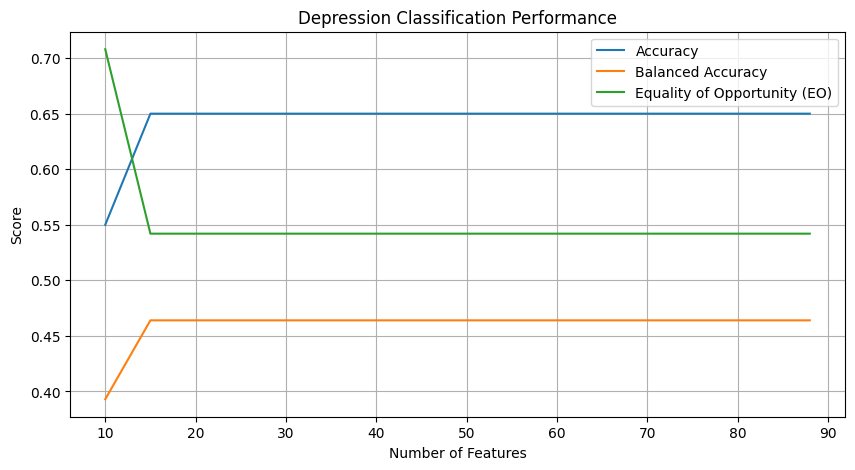

In [18]:
# Plotting the results
results = np.array(results)
plt.figure(figsize=(10, 5))
plt.plot(results[:, 0], results[:, 1], label='Accuracy')
plt.plot(results[:, 0], results[:, 2], label='Balanced Accuracy')
plt.plot(results[:, 0], results[:, 3], label='Equality of Opportunity (EO)')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Depression Classification Performance')
plt.legend()
plt.grid(True)
plt.show()

**e. Mitigating the bias via re-weighting the samples**

In [19]:
def calculate_weights(y):
    # Calculate the weights inversely proportional to class frequencies
    class_weights = y.value_counts(normalize=True)
    print(f"Class weights: {class_weights}")
    weights = 1.0 / class_weights
    print(f"Weights: {weights}")
    normalized_weights = len(y) * weights / weights.sum()
    print(f"Normalized weights: {normalized_weights}")
    return normalized_weights

In [20]:
gender_weights = calculate_weights(genders_train)
sample_weights = genders_train.map(gender_weights)
print(sample_weights.shape)

Class weights: Gender
1    0.602752
0    0.397248
Name: proportion, dtype: float64
Weights: Gender
1    1.659056
0    2.517321
Name: proportion, dtype: float64
Normalized weights: Gender
1    4330.0
0    6570.0
Name: proportion, dtype: float64
(10900,)


Weights are re-calculated for the gender to mitigate the bias. Weights calculation is based on the inverse proportion to the class frequencies. This weights for the gender are used to train and evaluate the model.

In [21]:
rf = RandomForestClassifier(max_depth=None, max_features= 'sqrt', min_samples_split= 5,
                                    n_estimators=300, random_state=42)

In [22]:
rf.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_test = rf.predict(X_test)

In [23]:
participant_final_preds_test = aggregate_predictions(y_pred_test)
y_true_test = y_test.groupby(participant_ids_test).mean().round().astype(int)
y_pred_final_test = pd.Series(participant_final_preds_test)

In [24]:
#Calculate accuracy and balanced accuracy
accuracy_test = accuracy_score(y_true_test, y_pred_final_test)
balanced_accuracy_test = balanced_accuracy_score(y_true_test, y_pred_final_test)

mask_and_tpr = calculate_tpr(y_true_test, y_pred_final_test)
male_mask_test, female_mask_test, tpr_male_test, tpr_female_test = mask_and_tpr[0], mask_and_tpr[1], mask_and_tpr[2], mask_and_tpr[3]
eo_test = 1 - abs(tpr_male_test - tpr_female_test)

In [25]:
#Print the evaluation metrics for the test set
print("Test Accuracy:", accuracy_test)
print("Test Balanced Accuracy:", round(balanced_accuracy_test,3))
print("Test Equality of Opportunity (EO):", round(eo_test,3))

#Print the evaluation metrics for male and female participants separately
print("Male Accuracy:", round(tpr_male_test,3))
print("Female Accuracy:", round(tpr_female_test,3))
print("Male Balanced Accuracy:", round(balanced_accuracy_score(y_true_test[male_mask_test], y_pred_final_test[male_mask_test]),3))
print("Female Balanced Accuracy:", balanced_accuracy_score(y_true_test[female_mask_test], y_pred_final_test[female_mask_test]))

Test Accuracy: 0.65
Test Balanced Accuracy: 0.464
Test Equality of Opportunity (EO): 0.542
Male Accuracy: 0.833
Female Accuracy: 0.375
Male Balanced Accuracy: 0.455
Female Balanced Accuracy: 0.5


In [26]:
genders_train.value_counts()

Gender
1    6570
0    4330
Name: count, dtype: int64

The accuracies of the model look similar before and after the re-calculation of the weights. This could be due to the minimal impact of sample re-weighting if the dataset is not significantly biased towards one gender. Based on the dataset, most of them are male. But there is no significance difference between the number of male and female data. Since random forest is robust, it is not sensitive to the changes in the sample weighting.